In [24]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

## 2 The Factors
### 1 Analyze the factors

In [ ]:
df = pd.read_excel("factor_pricing_data_monthly.xlsx", sheet_name="factors (excess returns)")
df.set_index("Date", inplace=True)
df

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118
...,...,...,...,...,...,...
2025-04-30,-0.0084,-0.0186,-0.0340,-0.0285,-0.0267,0.0497
2025-05-31,0.0606,-0.0072,-0.0288,0.0126,0.0251,0.0221
2025-06-30,0.0486,-0.0002,-0.0160,-0.0319,0.0145,-0.0264


In [26]:
mean = df.mean(axis=0) * 12
vol = df.std(axis=0) * np.sqrt(12)
sharpe = mean / vol

result = pd.DataFrame([mean, vol, sharpe], index = ["mean", "vol", "sharpe"])
result

,MKT,SMB,HML,RMW,CMA,UMD
mean,0.087552,0.006120,0.026039,0.044047,0.028288,0.060313
vol,0.156142,0.101274,0.108835,0.082931,0.072480,0.153352
sharpe,0.560718,0.060435,0.239249,0.531132,0.390284,0.393299


## 2. Factor Analysis


**From the result above, it is clear that each factor has a positive risk premium**

**To analyze how the factors have performed, we conduct the following analysis:**

In [27]:
df_2015 = df.loc["2015":]
df_2015

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
2015-01-31,-0.0309,-0.0093,-0.0345,0.0158,-0.0164,0.0374
2015-02-28,0.0614,0.0036,-0.0179,-0.0110,-0.0175,-0.0310
2015-03-31,-0.0109,0.0308,-0.0038,0.0007,-0.0062,0.0270
2015-04-30,0.0060,-0.0301,0.0180,0.0005,-0.0062,-0.0727
2015-05-31,0.0138,0.0082,-0.0111,-0.0176,-0.0083,0.0568
...,...,...,...,...,...,...
2025-04-30,-0.0084,-0.0186,-0.0340,-0.0285,-0.0267,0.0497
2025-05-31,0.0606,-0.0072,-0.0288,0.0126,0.0251,0.0221
2025-06-30,0.0486,-0.0002,-0.0160,-0.0319,0.0145,-0.0264


In [28]:
mean = df_2015.mean(axis=0) * 12
vol = df_2015.std(axis=0) * np.sqrt(12)
sharpe = mean / vol

result = pd.DataFrame([mean, vol, sharpe], index = ["mean", "vol", "sharpe"])
result

,MKT,SMB,HML,RMW,CMA,UMD
mean,0.117872,-0.023775,-0.016303,0.040012,-0.009141,0.020119
vol,0.157356,0.103166,0.129885,0.072632,0.082072,0.137387
sharpe,0.749078,-0.230455,-0.125520,0.550896,-0.111373,0.146438


**From the result above, it is clear that some of the factors have performed worse since 2015, such as SMB , CMA and UMD, which has a lower excess return mean after 2015. While some factors performed better in recent years, like US Equities**


## 3.Correlation Matrix Across Factors

<Axes: >

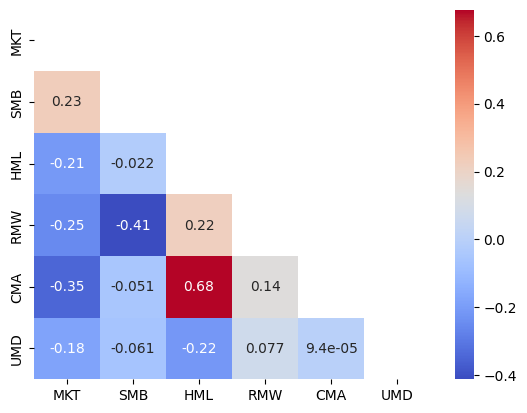

In [29]:
import seaborn as sn

correlation = df.corr()

mask = np.triu(np.ones_like(correlation, dtype=bool))

sn.heatmap(correlation, mask = mask, annot=True, cmap="coolwarm")

**The construction method did succceed in keeping correlations small. I don't think HML is redundant since it is only heavily correlated with CMA, while maintaining minimal correlations with other factors**

## 4. Tangency Portfolio

In [30]:
weights = np.linalg.inv(df.cov()) @ mean
weights = pd.Series(weights , index = df.columns)
weights

result_comparison = pd.DataFrame([sharpe, mean, weights], index = ["sharpe", "mean", "weights"])
result_comparison

,MKT,SMB,HML,RMW,CMA,UMD
sharpe,0.749078,-0.230455,-0.125520,0.550896,-0.111373,0.146438
mean,0.117872,-0.023775,-0.016303,0.040012,-0.009141,0.020119
weights,80.962364,-20.789616,-26.409773,96.873628,49.553125,16.154770


**Profitability seems the most important in the tangency portfolio, while the book market ratio factor seems the least important in driving revenue but rather provide a lot of diversification purposes**

In [33]:
df_adjusted = df[["MKT", "SMB", "HML","UMD"]]

mean_new = df_adjusted.mean(axis=0)

weights_new = np.linalg.inv(df_adjusted.cov()) @ mean_new
weights_new = pd.Series(weights_new , index = df_adjusted.columns)
weights_new


sharpe_new = mean_new / df_adjusted.std(axis=0)

result_comparison = pd.DataFrame([sharpe_new, mean_new, weights_new], index = ["sharpe", "mean", "weights"])
result_comparison


,MKT,SMB,HML,UMD
sharpe,0.161865,0.017446,0.069065,0.113536
mean,0.007296,0.000510,0.002170,0.005026
weights,5.169731,-0.702974,5.016042,4.247722


**MKT and HML has very high tangency weights now while SMB has the lowest tangency weight**